## BERT Classifier for Eng Hardware


In [43]:
#import libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow_text as text
from collections import OrderedDict

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

#hide warnings
import warnings
warnings.filterwarnings('ignore')


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
# Read recipe inputs
# Dataset pharmacy_dataset_reduced renamed to pharmacy_dataset_TEST by vkb6bn on 2023-03-08 17:42:52
data = pd.read_csv('prtspr_linked_tickets_s03_spans_joined_cleaned.csv')
#data = pd.read_csv('software_tickets.csv')
len(data)

16323

In [51]:
#"token_str.str.match('^([DV]{2}[0-9]{2})$') | token_str.str.match('^([CM]{2}[0-9]{2})$') | token_str.str.match('^([DA]{2}[0-9]{2})$') | token_str.str.match('^([PM]{2}[0-9]{2})$')"

data['ant_dv_mention']=data['ir_description'].str.findall(r'DV\d{2}', flags=re.IGNORECASE).str.join(" ").str.split(" ")
data['ant_cm_mention']=data['ir_description'].str.findall(r'CM\d{2}', flags=re.IGNORECASE).str.join(" ").str.split(" ")
data['ant_da_mention']=data['ir_description'].str.findall(r'DA\d{2}', flags=re.IGNORECASE).str.join(" ").str.split(" ")
data['ant_pm_mention']=data['ir_description'].str.findall(r'PM\d{2}', flags=re.IGNORECASE).str.join(" ").str.split(" ")
data['ant_pm_mention']=data['ir_description'].str.findall(r'PM\d{2}', flags=re.IGNORECASE).str.join(" ").str.split(" ")

In [53]:
data['ant_dv_mention']=data['ant_dv_mention'].apply(lambda x: ','.join(OrderedDict.fromkeys(x).keys()))

TypeError: 'float' object is not iterable

In [52]:
data.head(35)

,ticket,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware,eng_location,ict_components,PR_time_span_days,IR_time_span_days,ICT_time_span_days,ir_description,re_sentence1,ant_dv_mention,ant_cm_mention,ant_da_mention,ant_pm_mention
0,PRTSPR-5507,PRTSIR-2635,PRTSPR-5507,NaN,ittrash@alma.cl,Closed,False,teruomi.tsuno@nao.ac.jp,NaN,NaN,NaN,NaN,62.0,NaN,"While the mentioned MMEX was running, suddenly...","[""While the mentioned MMEX was running, sudden...",[],[],[],[]
1,PRTSPR-11972,PRTSIR-5893,PRTSPR-11972,NaN,ade-planners@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,NaN,NaN,NaN,NaN,0.0,NaN,Revealing the Low-Mass End of the Core Mass Fu...,"[""Revealing the Low-Mass End of the Core Mass ...",[],[],"[DA42, DA42, DA42]",[]
2,PRTSPR-126,PRTSIR-52,PRTSPR-126,NaN,ittrash@alma.cl,Closed,True,ade-sig-coordinators,NaN,NaN,NaN,NaN,133.0,NaN,The observation is Band#3 and run from 2013/07...,"[""The observation is Band#3 and run from 2013/...",[],[],[],[]
3,PRTSPR-6677,PRTSIR-3214,PRTSPR-6677,NaN,ittrash@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,NaN,NaN,NaN,NaN,152.0,NaN,SBEx failed to lock all FEs\n\n\n ERROR A Fai...,"[""SBEx failed to lock all FEs""]",[],"[CM12, CM09, CM11, CM07, CM05, CM04, CM02, CM01]",[],[]
4,PRTSPR-6232,PRTSIR-2995,PRTSPR-6232,NaN,ittrash@alma.cl,Closed,True,asaez,NaN,NaN,NaN,NaN,8.0,NaN,PM02 shows negative Trec in band 3 BB_1 (start...,"[""PM02 shows negative Trec in band 3 BB_1 (sta...",[],[],[],"[PM02, PM02, PM02, PM02, PM02, PM02, PM02, PM0..."
5,PRTSPR-13652,PRTSIR-6769,PRTSPR-13652,NaN,ade-planners@alma.cl,Closed,False,despada,NaN,NaN,NaN,NaN,116.0,NaN,When tried the SB 67P_HCN_2_07_TE from project...,"[""When tried the SB 67P_HCN_2_07_TE from proje...",[],[],[],[]
6,PRTSPR-38420,PRTSIR-14366,PRTSPR-38420,NaN,ade-amg-supervisors@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,DV07,FE62,NaN,NaN,0.0,NaN,dv07TrecXpol.png|width=750!\n \n! dv07TsysXpol...,"[""dv07TrecXpol.png|width=750!""]","[dv07, dv07]",[],[],[]
7,PRTSPR-10471,PRTSIR-5133,PRTSPR-10471,NaN,ade-planners@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,NaN,NaN,NaN,NaN,18.0,NaN,"an atmosphere calibrator, the SB crashed and o...","[""an atmosphere calibrator, the SB crashed and...",[DV02],[],[],[]
8,PRTSPR-23316,PRTSIR-10823,PRTSPR-23316,NaN,ade-amg-supervisors@alma.cl,Closed,False,pcarrill@alma.cl,DV25,NaN,NaN,NaN,6.0,NaN,"While running PI obs., the SB crashed showing ...","[""While running PI obs., the SB crashed showin...",[DV25],[],[],[]
9,PRTSPR-6574,PRTSIR-3161,PRTSPR-6574,NaN,ittrash@alma.cl,Closed,False,lluengo@alma.cl,NaN,NaN,NaN,NaN,176.0,NaN,"While observing :\n\n\n""SBEX"","" - "",""OSF-AOS"",...","[""While observing :""]",[],"[CM01, CM01, CM02, CM03, CM04, CM05, CM09, CM1...",[],[]


In [4]:
#data_red = data[['eng_location','re_sentence1']]
data_red = data[['eng_hardware','re_sentence1']]
data_red.head(3)

,eng_hardware,re_sentence1
0,NaN,"[""While the mentioned MMEX was running, sudden..."
1,NaN,"[""Revealing the Low-Mass End of the Core Mass ..."
2,NaN,"[""The observation is Band#3 and run from 2013/..."


In [5]:
#drop any missing values
data_red = data_red.dropna()
#reset index
data_red=data_red.reset_index(drop=True) 
data_red = data_red[data_red['re_sentence1'] != '[""]']
#shuffle data
data_red = shuffle(data_red)   
data_red

,eng_hardware,re_sentence1
6245,AOS ACA Corr Room,"[""recovered using new script""]"
2945,DV21,"[""AOS >c.STATUS()""]"
2992,DA55,"[""Movement of antenna DA55 was unexpectedly sh..."
6306,DA49,"[""SB failed with the following CORBA timeout:""]"
1624,DV04,"[""While observing SRM for DV04 went to \""not i..."
...,...,...
4481,DV24,"[""FrontEnd Ant: DV24 ..."
6044,DA50,"[""Looking in the antenna status we figured out..."
6088,CM01,"[""CM01 data were flagged due to ACD's being no..."
6276,DA42,"[""Mount component went into Stop status while ..."


In [6]:
#define the number of unique classes under 'label'
num_classes=len(data_red['eng_hardware'].unique())
num_classes

203

In [7]:
y_cat_labels = data_red["eng_hardware"].factorize()

In [8]:
y_cat_labels

(array([ 0,  1,  2, ..., 40, 61, 25], dtype=int64),
 Index(['AOS ACA Corr Room', 'DV21', 'DA55', 'DA49', 'DV04', 'DA48', 'All AEM',
        'DA44', 'DV13', 'DV14',
        ...
        'DV05.DV08.DV10', 'Otto Transporter', 'AOS BL Corr  Room.DA54',
        'CM01.CM03.CM09', 'CM02.CM08', 'All Melco 7m.CM05', 'DV19.DV22',
        'DA53.DV19.DV24', 'DA62.DA64', 'DA62.AOS64'],
       dtype='object', length=203))

In [9]:
y_cat_labels[0]

array([ 0,  1,  2, ..., 40, 61, 25], dtype=int64)

In [10]:
#define y variable
y = tf.keras.utils.to_categorical(data_red["eng_hardware"].factorize()[0], num_classes=num_classes)
#y

#split data into test and train
x_train, x_test, y_train, y_test = train_test_split(data_red['re_sentence1'], y, test_size=0.3)
len(x_train), len(x_test), len(y_train), len(y_test)

(4340, 1860, 4340, 1860)

In [11]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
#load bert with tensorflow hub
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

#function to get word embeddings
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

#test function
#get_embeddings([
#    "This is a test para ver el futuro of the model."])

In [13]:
#resource: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d#98ee
from keras import backend as K

#functions to find recall
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

#functions to find precision
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

#functions to find f1 score
def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [14]:
#define model
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
#x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dropout(0.35, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

bert_model = tf.keras.Model(i, x)

In [15]:
#define number of epochs
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.TrueNegatives(),
      tf.keras.metrics.FalsePositives(),
      tf.keras.metrics.AUC(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

#EarlyStopping callback to monitor validation loss
#if metric doesn't improve for at least 3 epochs (patience = 3)
    #training is interrupted and weights from epoch where the validation loss 
    #showed the best value (i.e. lowest) are restored (restore_best_weights = True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)


In [16]:
#compile model
bert_model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

In [17]:
help(bert_model.fit)

Help on method fit in module keras.engine.training:

fit(x=None, y=None, batch_size=None, epochs=1, verbose='auto', callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False) method of keras.engine.functional.Functional instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    Args:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
            (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
            (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
            if the model has named inputs.
          - A `tf.data` dataset. Should return a tuple
            of either `(inp

In [18]:
#fit model
model_fit = bert_model.fit(x_train, 
                      y_train, 
                      batch_size=32,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback], verbose=1)

Epoch 1/20
136/136 [==============================] - 152s 807ms/step - loss: 4.0551 - accuracy: 0.1915 - true_negatives: 876679.0000 - false_positives: 1.0000 - auc: 0.8253 - balanced_recall: 0.0018 - balanced_precision: 0.0026 - balanced_f1_score: 0.0021 - val_loss: 3.4196 - val_accuracy: 0.2828 - val_true_negatives: 375720.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.9052 - val_balanced_recall: 0.0039 - val_balanced_precision: 0.0048 - val_balanced_f1_score: 0.0042
Epoch 2/20
136/136 [==============================] - 84s 618ms/step - loss: 3.2318 - accuracy: 0.3200 - true_negatives: 876664.0000 - false_positives: 16.0000 - auc: 0.9089 - balanced_recall: 0.0100 - balanced_precision: 0.0128 - balanced_f1_score: 0.0111 - val_loss: 3.0378 - val_accuracy: 0.3742 - val_true_negatives: 375716.0000 - val_false_positives: 4.0000 - val_auc: 0.9267 - val_balanced_recall: 0.0134 - val_balanced_precision: 0.0169 - val_balanced_f1_score: 0.0149
Epoch 3/20
136/136 [========================

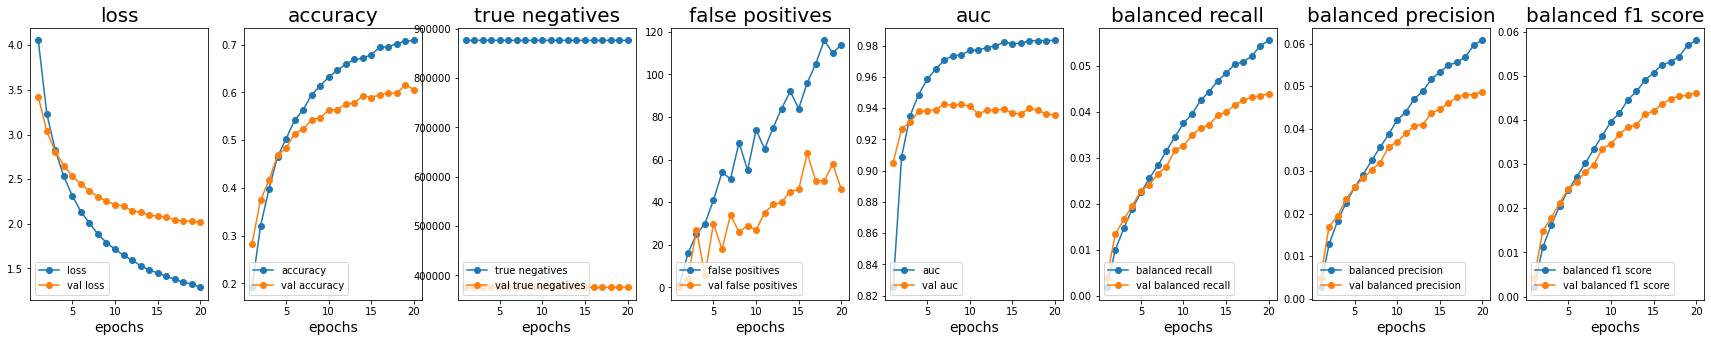

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [23]:
model_fit.history

{'loss': [4.055131912231445,
  3.2317731380462646,
  2.821012020111084,
  2.530022621154785,
  2.312246084213257,
  2.137310743331909,
  2.0065345764160156,
  1.8853119611740112,
  1.788755178451538,
  1.7137558460235596,
  1.6467851400375366,
  1.5935003757476807,
  1.5288265943527222,
  1.4851653575897217,
  1.4465430974960327,
  1.4130210876464844,
  1.3785980939865112,
  1.3461891412734985,
  1.3255702257156372,
  1.2863972187042236],
 'accuracy': [0.19147466123104095,
  0.3200460970401764,
  0.3983871042728424,
  0.46543779969215393,
  0.5029953718185425,
  0.5417050719261169,
  0.5635944604873657,
  0.59493088722229,
  0.6138249039649963,
  0.632488489151001,
  0.6460829377174377,
  0.659216582775116,
  0.66912442445755,
  0.671658992767334,
  0.6794930696487427,
  0.6949308514595032,
  0.6960829496383667,
  0.702534556388855,
  0.7069124579429626,
  0.7092165946960449],
 'true_negatives': [876679.0,
  876664.0,
  876655.0,
  876650.0,
  876639.0,
  876626.0,
  876629.0,
  876612

### Predictions

In [21]:
#predict class function
def predict_class(test_text):
  '''predict class of input text
  Args:
    - comments (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in bert_model.predict(test_text)]

In [24]:
data_red.head(10)

,eng_hardware,re_sentence1
6245,AOS ACA Corr Room,"[""recovered using new script""]"
2945,DV21,"[""AOS >c.STATUS()""]"
2992,DA55,"[""Movement of antenna DA55 was unexpectedly sh..."
6306,DA49,"[""SB failed with the following CORBA timeout:""]"
1624,DV04,"[""While observing SRM for DV04 went to \""not i..."
443,DA48,"[""Once Engineering returned this antenna to Sc..."
1249,All AEM,"[""In this ticket we are collecting all recurre..."
5689,DV04,"[""DV04: Subreflector Actuator 1 to 6 not Initi..."
912,DV21,"[""Antenna DA56 is showing slightly high ATM da..."
3705,DA44,"[""When starting observations and checking anet..."


## Predict eng_location

In [ ]:
predict_class([data_red['re_sentence1'][50]])

1/1 [==============================] - 1s 1s/step


[45]

## Review PRTSIR description sentence

In [ ]:
[data_red['re_sentence1'][50]]

['["DA56 was flagged due to \\"FrontEnd LO Amps not optimized\\" at f(LO1) = 171.485 GHz."]']

## Review PRTSPRT eng_location (true value)

In [ ]:
[data_red['eng_hardware'][45]]

['DV25']

## Map encoded (categorical data) to eng_location description

In [ ]:
location_map[location_map['label']==45]

KeyError: 'label'

In [170]:
location_map=dict(zip([str(n) for n in range(0,len(y_cat_labels[1]))] , y_cat_labels[1].values))
location_map

#sample_df['Predictions'] = sample_df['Predictions'].map(location_map)

{'0': 'AOS ACA Corr Room',
 '1': 'DV21',
 '2': 'DA55',
 '3': 'DA49',
 '4': 'DV04',
 '5': 'DA48',
 '6': 'All AEM',
 '7': 'DA44',
 '8': 'DV13',
 '9': 'DV14',
 '10': 'CM11',
 '11': 'DA59',
 '12': 'DV06',
 '13': 'DV07',
 '14': 'DA57',
 '15': 'DA45',
 '16': 'DA41',
 '17': 'AOS BL Corr  Room',
 '18': 'DA51',
 '19': 'CM10',
 '20': 'AOS LO Room',
 '21': 'DV20',
 '22': 'DV15',
 '23': 'CM02',
 '24': 'CM06',
 '25': 'DA64',
 '26': 'CM07',
 '27': 'DV11',
 '28': 'DA46',
 '29': 'AOS',
 '30': 'PM04',
 '31': 'OSF Control Room',
 '32': 'DA54',
 '33': 'DA65',
 '34': 'DV01',
 '35': 'CM09',
 '36': 'DV18',
 '37': 'DV10',
 '38': 'DV16',
 '39': 'DV02',
 '40': 'CM01',
 '41': 'DV22',
 '42': 'DA61',
 '43': 'PM01.PM02.PM04',
 '44': 'DV24',
 '45': 'DA56',
 '46': 'PM01',
 '47': 'DV25',
 '48': 'DA62',
 '49': 'DA43',
 '50': 'CM03',
 '51': 'DV17',
 '52': 'DA60',
 '53': 'DV23',
 '54': 'CM04',
 '55': 'AOS ACA Corr Room.PM04',
 '56': 'CM05',
 '57': 'DA58',
 '58': 'DV19',
 '59': 'DA52',
 '60': 'DV08',
 '61': 'DA42',
 '62'

In [172]:
hw_map=dict(zip([str(n) for n in range(0,len(y_cat_labels[1]))] , y_cat_labels[1].values))
hw_map

{'0': 'AOS ACA Corr Room',
 '1': 'DV21',
 '2': 'DA55',
 '3': 'DA49',
 '4': 'DV04',
 '5': 'DA48',
 '6': 'All AEM',
 '7': 'DA44',
 '8': 'DV13',
 '9': 'DV14',
 '10': 'CM11',
 '11': 'DA59',
 '12': 'DV06',
 '13': 'DV07',
 '14': 'DA57',
 '15': 'DA45',
 '16': 'DA41',
 '17': 'AOS BL Corr  Room',
 '18': 'DA51',
 '19': 'CM10',
 '20': 'AOS LO Room',
 '21': 'DV20',
 '22': 'DV15',
 '23': 'CM02',
 '24': 'CM06',
 '25': 'DA64',
 '26': 'CM07',
 '27': 'DV11',
 '28': 'DA46',
 '29': 'AOS',
 '30': 'PM04',
 '31': 'OSF Control Room',
 '32': 'DA54',
 '33': 'DA65',
 '34': 'DV01',
 '35': 'CM09',
 '36': 'DV18',
 '37': 'DV10',
 '38': 'DV16',
 '39': 'DV02',
 '40': 'CM01',
 '41': 'DV22',
 '42': 'DA61',
 '43': 'PM01.PM02.PM04',
 '44': 'DV24',
 '45': 'DA56',
 '46': 'PM01',
 '47': 'DV25',
 '48': 'DA62',
 '49': 'DA43',
 '50': 'CM03',
 '51': 'DV17',
 '52': 'DA60',
 '53': 'DV23',
 '54': 'CM04',
 '55': 'AOS ACA Corr Room.PM04',
 '56': 'CM05',
 '57': 'DA58',
 '58': 'DV19',
 '59': 'DA52',
 '60': 'DV08',
 '61': 'DA42',
 '62'

In [174]:
sample_df = data.sample(n=7)
sample_df.head()

,ticket,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware,eng_location,ict_components,PR_time_span_days,IR_time_span_days,ICT_time_span_days,ir_description,re_sentence1,Predictions,Correct_Hardware,correct_hw
7613,PRTSPR-53980,PRTSIR-18109,PRTSPR-53980,NaN,ade-amg-supervisors@alma.cl,Closed,True,ltiticho@alma.cl,DV14,Antenna HVAC,NaN,NaN,NaN,NaN,Due to having high temperature at the receiver...,"[""Due to having high temperature at the receiv...",DV18,0,0
5508,PRTSPR-60179,PRTSIR-19942,PRTSPR-60179,NaN,nicolas.pena@alma.cl,Resolved,True,npena@alma.cl,AOS,WCA3,NaN,NaN,NaN,NaN,AOS: Observation started when WCA temperature ...,"[""AOS: Observation started when WCA temperatur...",AOS,1,1
5250,PRTSPR-28125,ICT-5707,PRTSPR-28125,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,03 Control.11-01 Targets (scan execution),NaN,NaN,786.0,NaN,NaN,NaN,0,0
3431,PRTSPR-53813,PRTSIR-17753,PRTSPR-53813,NaN,ade-amg-supervisors@alma.cl,Closed,True,hmarroqu@alma.cl,DV04,Antenna ACU.Antenna Subreflector Mirror,NaN,NaN,NaN,NaN,"While observing SRM for DV04 went to ""not init...","[""While observing SRM for DV04 went to \""not i...",DV04,1,1
9309,PRTSPR-61057,PRTSIR-19656,PRTSPR-61057,NaN,claudio.follert@alma.cl,Resolved,True,franco.curotto@nao.ac.jp,DV11,LLC,NaN,NaN,NaN,NaN,In : llc=LLC('DV11') ...,"[""In : llc=LLC('DV11') ...",DV11,1,1


## Append to Sample DF

In [1]:
test_list=[]

#for idx,value in sample_df['re_sentence1'].iteritems():
for idx,value in sample_df['re_sentence1'].iteritems():

    #print(value)
    
    if isinstance(value,str) == True:
        
        list_value = [np.argmax(pred) for pred in bert_model.predict([value])]
        test_list.append(list_value[0])
    
    else:
        test_list.append('No Pred.')
        continue


#print(test_list)


#append to data frame
sample_df['Predictions'] = np.array(test_list)

#map coded hardware
sample_df['Predictions'] = sample_df['Predictions'].map(location_map)
sample_df


NameError: name 'sample_df' is not defined

## Append to original dataframe

In [30]:
test_list=[]

#for idx,value in data['re_sentence1'].iteritems():
for idx,value in data['re_sentence1'].iteritems():

    #print(value)
    
    if isinstance(value,str) == True:
        
        list_value = [np.argmax(pred) for pred in bert_model.predict([value])]
        temp_value = list_value[0]
        test_list.append(temp_value)
    
    else:
        test_list.append('No Pred.')
        continue


#print(test_list)


#append to data frame
data['Predictions'] = np.array(test_list)

#map coded hardware
data['Predictions'] = data['Predictions'].map(location_map)
data

1/1 [==============================] - 0s 45ms/step


,ticket,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware,eng_location,ict_components,PR_time_span_days,IR_time_span_days,ICT_time_span_days,ir_description,re_sentence1,Predictions
0,PRTSPR-5507,PRTSIR-2635,PRTSPR-5507,NaN,ittrash@alma.cl,Closed,False,teruomi.tsuno@nao.ac.jp,NaN,NaN,NaN,NaN,62.0,NaN,"While the mentioned MMEX was running, suddenly...","[""While the mentioned MMEX was running, sudden...",DV18
1,PRTSPR-11972,PRTSIR-5893,PRTSPR-11972,NaN,ade-planners@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,NaN,NaN,NaN,NaN,0.0,NaN,Revealing the Low-Mass End of the Core Mass Fu...,"[""Revealing the Low-Mass End of the Core Mass ...",DA64
2,PRTSPR-126,PRTSIR-52,PRTSPR-126,NaN,ittrash@alma.cl,Closed,True,ade-sig-coordinators,NaN,NaN,NaN,NaN,133.0,NaN,The observation is Band#3 and run from 2013/07...,"[""The observation is Band#3 and run from 2013/...",DA59
3,PRTSPR-6677,PRTSIR-3214,PRTSPR-6677,NaN,ittrash@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,NaN,NaN,NaN,NaN,152.0,NaN,SBEx failed to lock all FEs\n\n\n ERROR A Fai...,"[""SBEx failed to lock all FEs""]",AOS LO Room
4,PRTSPR-6232,PRTSIR-2995,PRTSPR-6232,NaN,ittrash@alma.cl,Closed,True,asaez,NaN,NaN,NaN,NaN,8.0,NaN,PM02 shows negative Trec in band 3 BB_1 (start...,"[""PM02 shows negative Trec in band 3 BB_1 (sta...",CM02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16318,PRTSPR-11803,PRTSIR-5808,PRTSPR-11803,NaN,ade-planners@alma.cl,Closed,True,ade-planners,NaN,NaN,NaN,NaN,0.0,NaN,SBEX failed:\n\n\n\n SSR/Array010-ACA/ObsCalAl...,"[""SBEX failed:""]",CM02
16319,PRTSPR-27273,PRTSIR-12304,PRTSPR-27273,NaN,ade-amg-supervisors@alma.cl,Closed,True,asaez,PM02.PM03,CCA9.WCA9,NaN,NaN,902.0,NaN,NaN,NaN,NaN
16320,PRTSPR-39829,PRTSIR-14672,PRTSPR-39829,NaN,daniel.herrera@alma.cl,Closed,True,lmconde,DV03,BL TFB,NaN,NaN,NaN,NaN,Scan\t Antenna\t Band\t Pol\tBaseband\t ...,"[""""]",AOS ACA Corr Room
16321,PRTSPR-30102,ICT-5991,PRTSPR-30102,NaN,software-jira@alma.cl,Closed,NaN,NaN,NaN,NaN,03-05 QuickLook,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.to_csv('software_predictions.csv')

In [32]:
data.sample(10)

,ticket,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware,eng_location,ict_components,PR_time_span_days,IR_time_span_days,ICT_time_span_days,ir_description,re_sentence1,Predictions
15880,PRTSPR-28838,PRTSIR-12245,PRTSPR-28838,NaN,ade-amg-supervisors@alma.cl,Closed,True,cfollert,DV17,PSD (Power Supply Digital Rack),NaN,NaN,0.0,NaN,"While DV17 was being part of an array, its PSD...","[""While DV17 was being part of an array, its P...",DV17
1812,PRTSPR-32736,PRTSIR-13088,PRTSPR-32736,NaN,jose.ortiz@alma.cl,Closed,True,gsiringo@alma.cl,AOS,LPR,NaN,NaN,NaN,NaN,In the last month (practically since we resume...,"[""In the last month (practically since we resu...",AOS
7747,PRTSPR-11731,PRTSIR-5771,PRTSPR-11731,NaN,ade-planners@alma.cl,Closed,True,czamoran,NaN,NaN,NaN,NaN,1.0,NaN,Weak source survey 2 (Version 0) --FAIL--\nSta...,"[""Weak source survey 2 (Version 0) --FAIL--""]",AOS BL Corr Room
3322,PRTSPR-57160,PRTSIR-19005,PRTSPR-57160,NaN,ade-amg-supervisors@alma.cl,Open,True,mrubina@alma.cl,DV16,Antenna ACU,NaN,NaN,0.0,NaN,"After performing a FAR, this antenna went to s...","[""After performing a FAR, this antenna went to...",DA50
8657,PRTSPR-43389,PRTSIR-15499,PRTSPR-43389,NaN,ade-amg-supervisors@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,DV03,LORR,NaN,NaN,0.0,NaN,Auto _generated ticket_\n \n \n \n\nAPE1:BL:DV...,"[""Auto _generated ticket_""]",DV03
10347,PRTSPR-55735,PRTSIR-12693,PRTSPR-55735,NaN,lorenzo.mconde@alma.cl,Closed,True,mwatanab,AOS ACA Corr Room,NaN,NaN,NaN,NaN,NaN,WARNING Unexpected scan and/or subscan number...,"[""WARNING Unexpected scan and/or subscan numb...",AOS ACA Corr Room
14991,PRTSPR-40133,PRTSIR-14715,PRTSPR-40133,NaN,lorenzo.mconde@alma.cl,Closed,True,lmconde,DV07,DTX 4,NaN,NaN,NaN,NaN,While executing some calibrations SBs in order...,"[""While executing some calibrations SBs in ord...",DV08
13059,PRTSPR-11626,PRTSIR-5714,PRTSPR-11626,NaN,ade-planners@alma.cl,Closed,True,ade-ig-correlator@alma.cl,NaN,NaN,NaN,NaN,101.0,NaN,*JLOG TIMESTAMP:* \n\ntarget after atmosphere ...,"[""*JLOG TIMESTAMP:* ""]",AOS ACA Corr Room
14258,PRTSPR-46573,PRTSIR-15850,PRTSPR-46573,NaN,pablo.zorzi@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,DA63,WCA7,NaN,NaN,NaN,NaN,"During the AIV-21487 Engineering Verification,...","[""During the AIV-21487 Engineering Verificatio...",DA63
2829,PRTSPR-33368,PRTSIR-5149,PRTSPR-33368,NaN,christopher.zamorano@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,All AEM,Drive Systems,NaN,NaN,NaN,NaN,In this ticket we are collecting all recurrenc...,"[""In this ticket we are collecting all recurre...",All AEM


# plotly chart thar

In [95]:
data['correct_hw'] = np.where(data['eng_hardware'] == data['Predictions'],1,0)

In [98]:
data.sample(5)

,ticket,prtspr_linked_ticket_final,key,labels,assignee_emailAddress,status_name,eng_assignee_active,eng_assignee_key,eng_hardware,eng_location,ict_components,PR_time_span_days,IR_time_span_days,ICT_time_span_days,ir_description,re_sentence1,Predictions,Correct_Hardware,correct_hw
7490,PRTSPR-37605,PRTSIR-14122,PRTSPR-37605,NaN,ade-amg-supervisors@alma.cl,Closed,True,ade-amg-supervisors@alma.cl,DV11,CCA7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6603,PRTSPR-34336,PRTSIR-13481,PRTSPR-34336,NaN,ade-amg-supervisors@alma.cl,Closed,False,pzorzi@alma.cl,DV05,CCA3.WCA3,NaN,NaN,35.0,NaN,NaN,NaN,NaN,0,0
9995,PRTSPR-34335,PRTSIR-9588,PRTSPR-34335,NaN,daniel.herrera@alma.cl,Closed,True,mwatanab,AOS ACA Corr Room,ACA MCI Module,NaN,NaN,NaN,NaN,*TimeStamp:* \nAfter the most recent FSR ACACo...,"[""*TimeStamp:* ""]",DV18,0,0
12258,PRTSPR-45603,PRTSIR-15881,PRTSPR-45603,NaN,ade-amg-supervisors@alma.cl,Closed,True,ppuelles@alma.cl,DV06,Antenna Shutter,NaN,NaN,NaN,NaN,cannot open the shutter and for that cannot be...,"[""cannot open the shutter and for that cannot ...",AOS ACA Corr Room,0,0
10785,PRTSPR-30444,PRTSIR-10321,PRTSPR-30444,NaN,jgatica@alma.cl,Closed,True,lmconde,NaN,NaN,NaN,NaN,NaN,NaN,Data reception errors (Lane frame receive err...,"[""Data reception errors (Lane frame receive e...",AOS ACA Corr Room,0,0


In [99]:
hw_cnt_df = pd.DataFrame(data.groupby('eng_hardware').size().sort_values(ascending=False)).reset_index().rename(columns={0:'total_label_count'})
hw_cnt_df

,eng_hardware,total_label_count
0,AOS ACA Corr Room,753
1,DV04,531
2,AOS,362
3,AOS BL Corr Room,219
4,DV10,163
...,...,...
211,DA41.DA56.DA60,1
212,DA41.DA49.DA50,1
213,CM09.AOS,1
214,CM08.DA50.DV08,1


In [101]:
hw_correct = pd.DataFrame(data.groupby('Predictions').agg({'correct_hw':'sum'}).sort_values(by='correct_hw',ascending=False)).reset_index().rename(columns={'Predictions':'eng_hardware'})
#hw_correct=hw_correct.rename(columns={'Predictions':'eng_hardware'}, axis=1)
hw_correct

,eng_hardware,correct_hw
0,AOS ACA Corr Room,644
1,DV04,404
2,AOS,244
3,AOS BL Corr Room,147
4,CM11,109
...,...,...
168,DA42.AOS64,1
169,DA41.DA56.DA64,1
170,DA41.DA49.DA50,1
171,CM09.AOS,1


In [164]:
hw_acc_df=pd.merge(hw_cnt_df,hw_correct,
                   on='eng_hardware',
                   how='outer')
hw_acc_df['pct_correct'] = 100*(hw_acc_df['correct_hw'] / hw_acc_df['total_label_count']).round(3)
hw_acc_df=hw_acc_df.sort_values(by='total_label_count',ascending=False).reset_index()
hw_acc_df

,index,eng_hardware,total_label_count,correct_hw,pct_correct
0,0,AOS ACA Corr Room,753,644.0,85.5
1,1,DV04,531,404.0,76.1
2,2,AOS,362,244.0,67.4
3,3,AOS BL Corr Room,219,147.0,67.1
4,4,DV10,163,41.0,25.2
...,...,...,...,...,...
211,155,CM02.CM03.CM04,1,1.0,100.0
212,154,CM02.CM08,1,1.0,100.0
213,153,CM03.CM04.CM05,1,NaN,NaN
214,152,CM03.CM07,1,1.0,100.0


## Plotly bar chart

In [105]:
import plotly.express as px
from plotly.subplots import make_subplots

In [165]:
from plotly.subplots import make_subplots

fig = make_subplots(shared_yaxes=True, shared_xaxes=True)

fig.add_bar(x=hw_acc_df['total_label_count'].head(10), y=hw_acc_df['eng_hardware'].head(10), opacity=0.6, width=0.7, name='Total Count', hovertemplate='%{y}',  orientation='h')
fig.add_bar(x=hw_acc_df['correct_hw'].head(10), y=hw_acc_df['eng_hardware'].head(10), width=0.5, name='% Accurate',text=hw_acc_df['pct_correct'], textposition='outside', orientation='h')

fig.update_layout(barmode='overlay', 
                  title= "Model Performance (Correct Classification)<br><sup>Accuracy% = Correct/Total</sup>",
                  xaxis_title='Hardware Issues', 
                  yaxis_title='Hardware',
                  yaxis=dict(autorange="reversed"))


fig.show()

In [169]:
import scipy.metrics

ModuleNotFoundError: No module named 'scipy.metrics'

In [176]:
x = [2, 5, 4, 7, 3]

w = [.8, 1.2, .65, 1.45, .3]

In [177]:
x*w

TypeError: can't multiply sequence by non-int of type 'list'